# Project work

## TASKS
- Explorative analysis
    - Data cleaning
    - Basic statistics
    - Figuring out which measures are important
- Statistical Tests
    - Estimation about parameter(s) that best represent the population
    - Hyphothese and its testing
- Must do a statistical model

## Reviewing criteria
- Data preparation
- Use of descriptive statistics
- Use of estimation and statistical test
- Argumentation for design choices
- interpretation of results

## Tasks from the hypothetical scheme
1. Characterise the individuals that are present in the data. Are there groups of similar persons?
    - Distributions for all categorical values
    - Find out if certain age, sex, and municipality groups have similiar activities
2. Estimate how much time on average households spend daily on each activity.
    - try out mean and medians for activities
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?
5. Which activities are associated with each other?

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# import seaborn as sns

# Loading data
df = pd.read_csv('./habits.data',
                sep=";",
                na_values=["?"],
                index_col=False,
                header=0)



# Naming columns 
# Listing variable types
# df['jasen'].values.dtype
# Deleting variables not needed
# df.drop(['jasen'], axis=1, inplace=True)
# Filling missing values
# print(df.index.size, end="\n\n")
# Calculating missing values
# print((df.isna()).sum(axis=0), end="\n\n")
# Deleting missing values
# print(df.dropna().index.size, end="\n\n")

Ikäluokkaryhmiä 1-2 eli alle 20 vuotiaita ei ole tuloksissa ollenkaan
Vastanneiden painopiste intuitiivisesti on jossain luokan 6 kohdalla.
Vastaa intuitiivisesti yläpäähän painottuvaa normaalijakaumaa

### Demographic variables
- kohde - household ID: nominal
- jasen - member ID (within household): nominal
- pvknro - day of week: nominal
    - 1 = working day
    - 2 = weekend

- sp - sex: nominal
    - 1 = male
    - 2 = female
- IKAL1 - age group: ordinal
    - 1 = 10-14 years old
    - 2 = 15-19 years old
    - 3 = 20-24 years old
    - 4 = 25-34 years old
    - 5 = 35-44 years old
    - 6 = 45-54 years old
    - 7 = 55-64 years old
    - 8 = 65-74 years old
    - 9 = 75- years old

- ASALUE - living environment: nominal
    - 1 = city
    - 2 = municipality
    - 3 = rural area

### Activity variables
Time spent on activities (measured in minutes): ratio

- V1 - working: ratio
- V5 - cooking: ratio
- V21 - childcare: ratio
- V22 - reading and playing with children: ratio

Place visited in past 12 months 
- Values: indicator
    - 1 = yes
    - 2 = no

- H1a_A - cinema: indicator
- H1b_A - theater: indicator


In [94]:
# Keep relevant columns
columns_to_keep = ['kohde', 'jasen', 'pvknro', 'sp', 'IKAL1', 'ASALUE', 'V1', 'V21', 'V22', 'V5', 'H1a_A', 'H1b_A']
df = df[columns_to_keep]
print(df)


     kohde  jasen  pvknro  sp  IKAL1  ASALUE   V1 V21 V22  V5  H1a_A  H1b_A
0    50002      1       1   1      6     1.0    0   0   0   0    2.0    2.0
1    50002      1       2   1      6     1.0  380   0   0  10    2.0    2.0
2    50003      1       1   2      5     2.0    0  50   0  60    2.0    1.0
3    50003      1       2   2      5     2.0    0  50   0  50    2.0    1.0
4    50004      2       1   1      7     1.0  640   0   0   0    2.0    1.0
..     ...    ...     ...  ..    ...     ...  ...  ..  ..  ..    ...    ...
740  51980      1       2   2      6     2.0  460   0   0  20    1.0    1.0
741  51981      2       1   1      5     1.0    0   0   0   0    NaN    NaN
742  51981      2       2   1      5     1.0    0  10   0   0    NaN    NaN
743  51983      1       1   2      8     3.0  NaN   0   0  40    1.0    2.0
744  51983      1       2   2      8     3.0    0   0   0  90    1.0    2.0

[745 rows x 12 columns]


In [95]:
# df = df.apply(pd.to_numeric, errors='coerce')
# print(df.sum(axis=0).sort_values(ascending=False), end="\n\n")

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kohde   745 non-null    int64  
 1   jasen   745 non-null    int64  
 2   pvknro  745 non-null    int64  
 3   sp      745 non-null    int64  
 4   IKAL1   745 non-null    int64  
 5   ASALUE  745 non-null    float64
 6   V1      734 non-null    object 
 7   V21     739 non-null    object 
 8   V22     738 non-null    object 
 9   V5      740 non-null    object 
 10  H1a_A   701 non-null    float64
 11  H1b_A   701 non-null    float64
dtypes: float64(3), int64(5), object(4)
memory usage: 70.0+ KB


In [97]:
# Describes the data 
df.describe().round(2)

,kohde,jasen,pvknro,sp,IKAL1,ASALUE,H1a_A,H1b_A
count,745.00,745.00,745.00,745.00,745.00,745.00,701.00,701.00
mean,51016.84,1.36,1.49,1.52,6.10,1.58,3.36,3.27
std,587.44,0.48,0.50,0.50,1.59,0.82,20.07,17.48
min,50002.00,1.00,1.00,1.00,3.00,1.00,0.00,0.00
25%,50518.00,1.00,1.00,1.00,5.00,1.00,1.00,1.00
50%,51053.00,1.00,1.00,2.00,6.00,1.00,2.00,2.00
75%,51524.00,2.00,2.00,2.00,7.00,2.00,2.00,2.00
max,51983.00,2.00,2.00,2.00,9.00,3.00,360.00,300.00


In [98]:
df.isnull().sum()

# Paljon null-arvoja, poistetaanko? poistetaan
# Paljon nollia, pitäisikö jättää vain rivit jotka ovat täynnä dataa? ei poisteta

kohde      0
jasen      0
pvknro     0
sp         0
IKAL1      0
ASALUE     0
V1        11
V21        6
V22        7
V5         5
H1a_A     44
H1b_A     44
dtype: int64

In [99]:
df.nunique()

kohde     378
jasen       2
pvknro      2
sp          2
IKAL1       7
ASALUE      3
V1         82
V21        38
V22        25
V5         30
H1a_A       7
H1b_A       7
dtype: int64

In [100]:
df.sort_values(by='IKAL1', ascending=False).head(5)

,kohde,jasen,pvknro,sp,IKAL1,ASALUE,V1,V21,V22,V5,H1a_A,H1b_A
382,51075,2,2,1,9,3.0,0,0,0,10,NaN,NaN
431,51212,1,1,1,9,1.0,0,0,0,140,2.0,1.0
346,50977,1,2,2,9,1.0,0,0,0,20,1.0,2.0
654,51750,1,2,1,9,1.0,60,0,0,0,2.0,1.0
653,51750,1,1,1,9,1.0,0,0,0,0,2.0,1.0


### Data cleaning
At first glance NaN-values will be dropped, but may change over the study if effect on results seem good either way. 

At first I thought of filling zero values with mean or medians but they would heavily influence the results pushing up correlation and other metrics. It seems that particioners have deliberatley chosen 0 minutes and therefore they are not active on these metrics at all. This must be included in the results.

In [101]:
df_filtered = df.dropna()
# Drop rows with more than 1 zero
#df_filtered = df_filtered[df_filtered.apply(lambda x: (x == 0).sum() < 2, axis=1)]
# Replace zeros with mean values
#df_filled_mean = df_filtered.apply(lambda x: x.replace(0, x.mean()) if x.name in df_filtered.columns else x)
# Replace zeros with median values
#df_filled_median = df_filtered.apply(lambda x: x.replace(0, x.median()) if x.name in df_filtered.columns else x)
len(df_filtered)

668

<Axes: title={'center': 'Density Plot of IKAL1'}, ylabel='Density'>

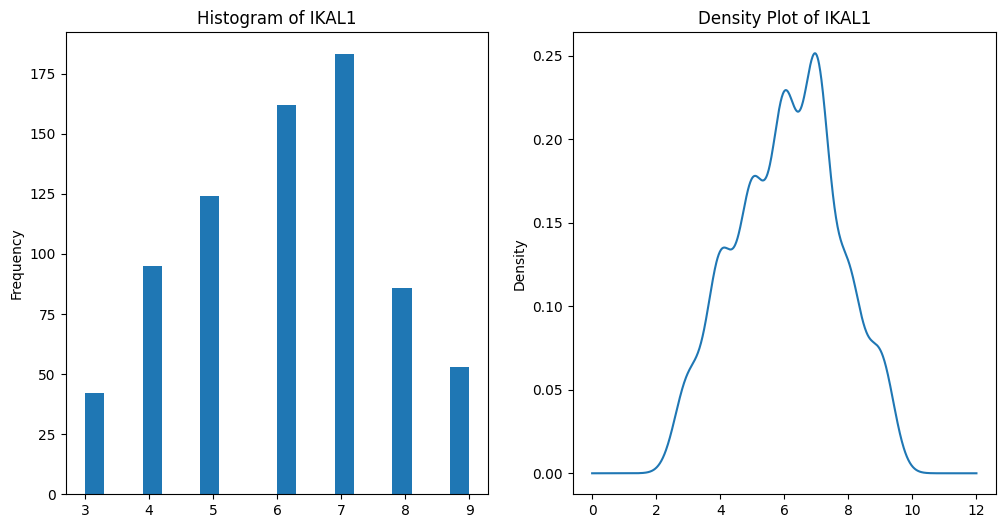

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df['IKAL1'].sort_values().plot(kind='hist', bins=20, ax=axes[0], title='Histogram of IKAL1')

# Density plot

df['IKAL1'].dropna().sort_values().plot(kind='density', ax=axes[1], title='Density Plot of IKAL1')

# plt.tight_layout()
# plt.show()

### Correlation

Overall could be assumed that age, sex and region will group particioners similiarly.

Correlations still are quite low generally with max values at around 0.43 and -0.27

In [106]:
# Needs to be done with numeric data only
df.corr().where(lambda x: (x < -0.2) | (x > 0.2)).round(3)

# Measured in minutes
# V1 - working
# V5 - cooking
# V21 - childcare
# V22 - reading and playing with children

# 1 = yes, 2 = no   
# H1a_A - cinema
# H1b_A - theater

ValueError: could not convert string to float: '00:00'

In [47]:
# Counting individual values in column 'jasen' and testing if errors
one, two, faults = 0, 0, 0
fault_values = []
count = len(df_filtered.jasen)

for value in df.jasen.values:
    if value == 1:
        one += 1
    elif value == 2:
        two += 1 
    else:
        print(value)
        fault_values.append(value)
        
if count != one + two:
    print("Error in counting")

print(f" 1's: {one}\n", f"2's: {two}\n", f"Total count: {count}\n", f"Fault values: {fault_values}")

Error in counting
 1's: 478
 2's: 267
 Total count: 601
 Fault values: []
